# Romanization using Transformers

In [1]:
import tensorflow as tf
import numpy as np
from hangul_utils import split_syllables, join_jamos
import pickle

2022-12-12 21:30:28.699643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 21:30:28.736399: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-12-12 21:30:29.548308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:30:29.563871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:30:29.564000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
tf.config.experimental.set_memory_growth(gpus[0], True)

## Data Generation

In [5]:
with open("kor_syllable.pkl", "rb") as f:
    kr_list = pickle.load(f)

In [6]:
with open("eng_syllable.pkl", "rb") as f:
    en_list = pickle.load(f)

In [7]:
len(kr_list)

86191

In [8]:
len(en_list)

86191

In [9]:
# Get indices for kor character
temp_dict_kr = {}
temp_dict_kr["<sos>"] = 0 # Not used for now
temp_dict_kr["<eos>"] = 0 # Not used for now
for string in kr_list:
    for char in string:
        temp_dict_kr[char] = 0

In [10]:
# Get indices for eng character
temp_dict_en = {}
temp_dict_en["<sos>"] = 0 # Not used for now
temp_dict_en["<eos>"] = 0 # Not used for now
temp_dict_en["-"] = 0
for string in en_list:
    for char in string:
        temp_dict_en[char] = 0

In [11]:
len(temp_dict_kr)

45

In [12]:
len(temp_dict_en)

29

In [13]:
indices_dict_kr = {}
key_list = list(temp_dict_kr.keys())
for i in range(len(temp_dict_kr)):
    indices_dict_kr[key_list[i]] = i+1 # 0th index for padding

In [14]:
indices_dict_kr["<sos>"]

1

In [15]:
indices_dict_kr["<eos>"]

2

In [16]:
indices_dict_en = {}
key_list = list(temp_dict_en.keys())
for i in range(len(temp_dict_en)):
    indices_dict_en[key_list[i]] = i+1 # 0th index for padding

In [17]:
indices_dict_en["<sos>"]

1

In [18]:
# Memory management:
kr_list = kr_list[0:len(kr_list)//7]
en_list = en_list[0:len(en_list)//7]

In [19]:
len(kr_list)

12313

In [20]:
def char_to_idx(string, indices_dict):
    index_list = []
    index_list.append(1) #<sos> append by default
    for char in string:
        index_list.append(indices_dict[char])
    index_list.append(2) #<eos> append by default
    return index_list

In [21]:
char_to_idx(kr_list[0], indices_dict_kr)

[1, 3, 4, 5, 6, 7, 5, 7, 8, 9, 10, 2]

In [22]:
reversed_dict_kr = {}
for key in indices_dict_kr.keys():
    reversed_dict_kr[indices_dict_kr[key]] = key

In [23]:
reversed_dict_en = {}
for key in indices_dict_en.keys():
    reversed_dict_en[indices_dict_en[key]] = key

In [24]:
def idxlist_to_char(idxlist, reversed_dict):
    result_list = []
    for idx in idxlist:
        if idx == 0: # padding idx
            break
        result_list.append(reversed_dict[int(idx)])
    return result_list

In [25]:
idxlist_to_char(char_to_idx(kr_list[0], indices_dict_kr), reversed_dict_kr)

['<sos>', 'ㅈ', 'ㅓ', 'ㄴ', 'ㄹ', 'ㅏ', 'ㄴ', 'ㅏ', 'ㅁ', 'ㄷ', 'ㅗ', '<eos>']

In [26]:
idxlist_to_char(char_to_idx(en_list[0], indices_dict_en), reversed_dict_en)

['<sos>', 'j', 'e', 'o', 'l', 'l', 'a', 'n', 'a', 'm', '-', 'd', 'o', '<eos>']

In [27]:
def generate_data(str_list, indices_dict, is_target = False):
    result_list = []
    result_list_targ = []
    for string in str_list:
        idx_list = char_to_idx(string, indices_dict)
        if is_target:
            nparr = np.array(idx_list[:-1])
            result_list.append(idx_list[:-1])
            result_list_targ.append(idx_list[1:])
        else:
            result_list.append(idx_list)
    if is_target:
        return result_list, result_list_targ
    else:
        return result_list

In [28]:
en_data = generate_data(en_list, indices_dict_en)
kr_data, kr_data_label = generate_data(kr_list, indices_dict_kr, is_target=True)

### We need to pad

In [29]:
en_data_max = max(list(map(len, en_data)))
en_data_max

35

In [30]:
kr_data_max = max(list(map(len, kr_data)))
kr_data_max

27

In [31]:
def get_padded_arr(idxlist, maxlen):
    result = []
    for item in idxlist:
        arr = np.zeros(maxlen)
        for i, sub in enumerate(item):
            arr[i] = sub
        result.append(arr)
    return result

In [32]:
en_data = get_padded_arr(en_data, en_data_max)
kr_data = get_padded_arr(kr_data, kr_data_max)
kr_data_label = get_padded_arr(kr_data_label, kr_data_max)

## Splitting data:

In [33]:
import random # For Shuffling
random.seed(2022)

#### Shuffle

In [34]:
zipped = zip(en_data, kr_data, kr_data_label)
zipped_list = list(zipped)

In [35]:
random.shuffle(zipped_list)

In [36]:
en_data = []
kr_data = []
kr_data_label = []
for tup in zipped_list:
    en_data.append(tup[0])
    kr_data.append(tup[1])
    kr_data_label.append(tup[2])

In [37]:
# Save the dictionaries:
with open("indices_kr.pkl", "wb") as f:
    pickle.dump(indices_dict_kr, f)
with open("indices_en.pkl", "wb") as f:
    pickle.dump(indices_dict_en, f)
with open("rev_indices_kr.pkl", "wb") as f:
    pickle.dump(reversed_dict_kr, f)
with open("rev_indices_en.pkl", "wb") as f:
    pickle.dump(reversed_dict_en, f)

#### (Train-Val)-Test split:

In [38]:
# 80-20 split. No test data, will test with just some examples
x_en_train = en_data[0: round(len(en_data)*0.8)]
x_en_test = en_data[round(len(en_data)*0.8) :]
x_kr_train = kr_data[0: round(len(kr_data)*0.8)]
x_kr_test = kr_data[round(len(kr_data)*0.8) : ]
y_kr_train = kr_data_label[0: round(len(kr_data_label)*0.8)]
y_kr_test = kr_data_label[round(len(kr_data_label)*0.8) : ]

### Batches:

In [39]:
# def generate_batches(data, n_batch):
#     result = []
#     data = data.copy()
#     if len(data) % n_batch != 0:
#         fill = n_batch - (len(data) % n_batch)
#         fill_idxs = [random.randint(0, len(data)-1) for _ in range(fill)] # pick random integers to duplicate data
#         for idx in fill_idxs:
#             data.append(data[idx])
#     for i in range(0, len(data), n_batch):
#         result.append(data[i:i+n_batch])
#     return tf.convert_to_tensor(result, dtype = tf.float32)

In [40]:
# # Train dataset
# x_en_train = generate_batches(x_en_train, 64)
# x_kr_train = generate_batches(x_kr_train, 64)
# y_kr_train = generate_batches(y_kr_train, 64)

In [41]:
# # Test dataset
# x_en_test = tf.convert_to_tensor(x_en_test, dtype = tf.float32)
# x_kr_test = tf.convert_to_tensor(x_kr_test, dtype = tf.float32)
# y_kr_test = tf.convert_to_tensor(y_kr_test, dtype = tf.float32)

## Memory management:
Delete:
- kr_list
- en_list
- zipped
- en_data
- kr_data
- kr_data_label

In [42]:
del kr_list, en_list, zipped, en_data, kr_data, kr_data_label

# Modeling
## Code Acquired from Tensorflow 

In [43]:
# Positional encoding using the traditional Sinusoidal functions
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)


In [44]:
# Positional embedding to be concatenated
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [45]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [46]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


In [47]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


In [48]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


In [49]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


In [50]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


In [51]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [52]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x


In [53]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x


In [54]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='relu')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


## Training

In [55]:
# Basic Config
num_layers = 4
d_model = 256
dff = 256
num_heads = 4
dropout_rate = 0.2
vocab_size_kr = len(indices_dict_kr.keys()) - 2
vocab_size_en = len(indices_dict_en.keys()) - 2

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=40000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [57]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipvalue=0.5)

# optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate)
# optimizer = tf.keras.optimizers.experimental.SGD(learning_rate)


2022-12-12 21:30:34.831291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 21:30:34.832872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:30:34.833031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 21:30:34.833085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

In [58]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Train Step')

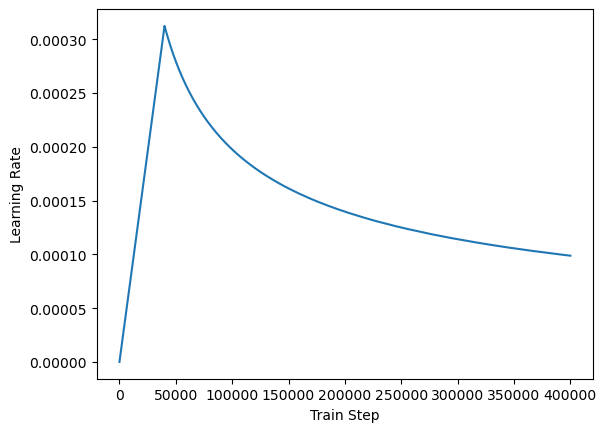

In [59]:
plt.plot(learning_rate(tf.range(400000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')


In [60]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)#, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


# Train

In [61]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= vocab_size_en,
    target_vocab_size= vocab_size_kr,
    dropout_rate=dropout_rate)


In [62]:
# Train dataset
x_en_train = tf.convert_to_tensor(x_en_train, dtype = tf.float32)
y_kr_train = tf.convert_to_tensor(y_kr_train, dtype = tf.float32)
x_kr_train = tf.convert_to_tensor(x_kr_train, dtype = tf.float32)
# Test dataset
x_en_test = tf.convert_to_tensor(x_en_test, dtype = tf.float32)
x_kr_test = tf.convert_to_tensor(x_kr_test, dtype = tf.float32)
y_kr_test = tf.convert_to_tensor(y_kr_test, dtype = tf.float32)

In [63]:
train = tf.data.Dataset.from_tensor_slices(((x_en_train, x_kr_train), y_kr_train))

In [64]:
# So that it only knows the input shape
output = transformer((x_en_train[0:1 , :], x_kr_train[0:1 , :]))

2022-12-12 21:30:36.948853: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-12 21:30:37.044151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


In [65]:
transformer.summary()


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4744960   
                                                                 
 decoder (Decoder)           multiple                  8958720   
                                                                 
 dense_16 (Dense)            multiple                  11051     
                                                                 
Total params: 13,714,731
Trainable params: 13,714,731
Non-trainable params: 0
_________________________________________________________________


In [66]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [67]:
batch_size = 32
epochs = 100
ds = train.batch(batch_size, drop_remainder=True)
# transformer.fit(x = (x_en_train, x_kr_train), y= y_kr_train,
transformer.fit(x = ds,
#                 batch_size=batch_size,
                epochs=epochs,
                validation_data = ((x_en_test, x_kr_test), y_kr_test))

Epoch 1/100
307/307 [==============================] - 15s 39ms/step - loss: 2.5209 - masked_accuracy: 0.0256 - val_loss: 1.5668 - val_masked_accuracy: 0.0914
Epoch 2/100
307/307 [==============================] - 11s 36ms/step - loss: 1.3800 - masked_accuracy: 0.1847 - val_loss: 1.1023 - val_masked_accuracy: 0.3360
Epoch 3/100
307/307 [==============================] - 11s 36ms/step - loss: 1.0652 - masked_accuracy: 0.3476 - val_loss: 0.9006 - val_masked_accuracy: 0.4509
Epoch 4/100
307/307 [==============================] - 11s 36ms/step - loss: 0.9027 - masked_accuracy: 0.4431 - val_loss: 0.7760 - val_masked_accuracy: 0.5173
Epoch 5/100
307/307 [==============================] - 11s 35ms/step - loss: 0.7854 - masked_accuracy: 0.5018 - val_loss: 0.6521 - val_masked_accuracy: 0.5829
Epoch 6/100
307/307 [==============================] - 11s 35ms/step - loss: 0.6410 - masked_accuracy: 0.5859 - val_loss: 0.4107 - val_masked_accuracy: 0.7263
Epoch 7/100
307/307 [=========================

307/307 [==============================] - 11s 36ms/step - loss: 0.0168 - masked_accuracy: 0.9880 - val_loss: 0.0177 - val_masked_accuracy: 0.9897
Epoch 53/100
307/307 [==============================] - 11s 37ms/step - loss: 0.0165 - masked_accuracy: 0.9882 - val_loss: 0.0177 - val_masked_accuracy: 0.9905
Epoch 54/100
307/307 [==============================] - 11s 35ms/step - loss: 0.0165 - masked_accuracy: 0.9884 - val_loss: 0.0195 - val_masked_accuracy: 0.9881
Epoch 55/100
307/307 [==============================] - 11s 35ms/step - loss: 0.0164 - masked_accuracy: 0.9885 - val_loss: 0.0174 - val_masked_accuracy: 0.9898
Epoch 56/100
307/307 [==============================] - 11s 35ms/step - loss: 0.0162 - masked_accuracy: 0.9881 - val_loss: 0.0173 - val_masked_accuracy: 0.9903
Epoch 57/100
307/307 [==============================] - 11s 35ms/step - loss: 0.0157 - masked_accuracy: 0.9889 - val_loss: 0.0206 - val_masked_accuracy: 0.9878
Epoch 58/100
307/307 [==============================]

In [70]:
transformer.save_weights('./checkpoints/my_checkpoint')

In [71]:
def translate_main(model, indices_dict, reversed_dict, string):
    output_list = []
    idx_list = []
    string = char_to_idx(string, indices_dict)
    string = get_padded_arr([string], en_data_max)
    string = tf.convert_to_tensor(string, dtype=tf.float32)
    output = tf.constant(1, dtype=tf.float32, shape=(1, 1)) # value = 1 => "<sos>"
    counter = 0 # For safety
    while True:
        if counter > 100:
            print("Something went wrong with the input")
            break
        prediction = transformer([string, output], training=False)
        ind_predicted = np.argmax(prediction[:, -1, :]) # Always capture the last prediction's argmax. 
        if ind_predicted == 2: # 2 is "<eos>"
            return join_jamos(output_list)
        else:
            output_list.append(reversed_dict[ind_predicted])
            idx_list.append(ind_predicted)
            output = tf.expand_dims(tf.convert_to_tensor(idx_list, dtype=tf.float32), 0)
        counter += 1

In [72]:
from functools import partial
translate_kr_en = partial(translate_main, transformer, indices_dict_en, reversed_dict_kr)

In [73]:
translate_kr_en("hajun")

'하준'

In [74]:
testing = ["hajun", "jeon-hye-woong", "haeangil", "apeum", "gangnam", "africa", "aprica", "papri-ka", "seocho", "galwolilgil"]

In [75]:
for token in testing:
    print(translate_kr_en(token))

하준
전혜고원
해안길
아픔
강남
아리리차
압리차
팝리가
서초
갈월릴길
